In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re 
from fractions import Fraction
from rapidfuzz import process, fuzz 

from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.cluster import KMeans

from tensorflow.keras import layers, backend as K

import warnings

warnings.simplefilter(action="ignore", category=UserWarning)

2025-02-14 00:13:55.689521: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-14 00:13:55.695161: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-14 00:13:55.717493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739481235.753360   78921 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739481235.764179   78921 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-14 00:13:55.793721: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
df = pd.read_csv('products_2.csv')

In [3]:
df.head()

,id,product_name,product_category_id,product_category_name,product_type_numeric,product_type_text,product_manufacturer_id,product_manufacturer_name
0,512842,Layers Mash,318,Feeds,1.0,kg,608.0,Lucky Feeds
1,513291,Layers Mash,313,Minerals and Supplements,70.0,kg,2314.0,Mapato Feeds
2,514788,Layers Mash,318,Feeds,10.0,kg,5311.0,murimi feeds
3,514789,Layers Mash,318,Feeds,1.0,kg,5311.0,murimi feeds
4,514845,Layers Mash,318,Feeds,5.0,kg,25878.0,Meru Central Ltd


In [4]:
df.columns

Index(['id', 'product_name', 'product_category_id', 'product_category_name',
       'product_type_numeric', 'product_type_text', 'product_manufacturer_id',
       'product_manufacturer_name'],
      dtype='object')

In [5]:
df.describe()

,id,product_category_id,product_type_numeric,product_manufacturer_id
count,50000.000000,50000.000000,4.679300e+04,49601.000000
mean,303101.912560,396.820060,3.276169e+02,5128.425616
std,169259.928945,593.278557,5.707254e+04,6982.752270
min,27.000000,1.000000,0.000000e+00,0.000000
25%,161488.750000,313.000000,2.000000e+00,136.000000
50%,295918.000000,318.000000,1.000000e+01,2676.000000
75%,458799.750000,318.000000,5.000000e+01,6629.000000
max,573441.000000,9609.000000,1.234568e+07,28446.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         50000 non-null  int64  
 1   product_name               50000 non-null  object 
 2   product_category_id        50000 non-null  int64  
 3   product_category_name      50000 non-null  object 
 4   product_type_numeric       46793 non-null  float64
 5   product_type_text          47514 non-null  object 
 6   product_manufacturer_id    49601 non-null  float64
 7   product_manufacturer_name  49575 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 3.1+ MB


In [7]:
# Checking count of unique values in the categorical column
categorical_columns = df.select_dtypes(include=['object']).columns

# Create a data frame to store the count of unique values in the categorical columns
unique_values = pd.DataFrame(columns=['column_name', 'unique_values_count'])

for column in categorical_columns:
    unique_values = unique_values._append({'column_name': column, 'unique_values_count': df[column].nunique()}, ignore_index=True)

unique_values

,column_name,unique_values_count
0,product_name,13576
1,product_category_name,115
2,product_type_text,579
3,product_manufacturer_name,4414


In [8]:
# Checking for missing values
missing_values = pd.DataFrame(columns=['column_name', 'missing_values_count'])

for column in df.columns:
    missing_values = missing_values._append({'column_name': column, 'missing_values_count': df[column].isnull().sum()}, ignore_index=True)
    
missing_values

,column_name,missing_values_count
0,id,0
1,product_name,0
2,product_category_id,0
3,product_category_name,0
4,product_type_numeric,3207
5,product_type_text,2486
6,product_manufacturer_id,399
7,product_manufacturer_name,425


# Data Cleaning

In [9]:
# Putting categorical text into Camel Case for uniformity
df['product_name'] = df['product_name'].str.title()
df['product_manufacturer_name'] = df['product_manufacturer_name'].str.title()
df['product_category_name'] = df['product_category_name'].str.title()

In [10]:
def clean_text(text):
    
    # Replace hyphens and remove brackets
    text = text.replace('-', ' ')
    text = text.replace('_', ' ')
    text = text.replace('(', '').replace(')', ' ')
    text = text.replace('[', '').replace(']', ' ')
    return text

df['product_name'] = df['product_name'].apply(clean_text)

In [11]:
# Extracting the numeric and unit if missing from the product name
def extract_and_fill(row):
    pattern = r'(\d+)\s*(kg|g|l|ml|Litre|Kilogram|Kg|G|kg|KG|ML|Ml|Kgs)'
    match = re.search(pattern, row['product_name'], re.IGNORECASE)
    if match:
        numeric, unit = match.groups()
        if pd.isnull(row['product_type_numeric']):
            row['product_type_numeric'] = int(numeric)
        if pd.isnull(row['product_type_text']):
            row['product_type_text'] = unit.lower()  # Convert to lowercase for consistency
    return row


# Apply the function to the dataframe
df = df.apply(extract_and_fill, axis=1)

In [12]:
# Function to remove numeric and unit from product_name
def remove_numeric_and_unit(row):
    pattern = r'(\d+)\s*(kg|g|l|ml|Litre|Kilogram|Kg|G|kg|KG|ML|Ml|Kgs)'
    row['product_name'] = re.sub(pattern, '', row['product_name'], flags=re.IGNORECASE).strip()
    return row

# Apply the function to remove numeric values and units from product_name
df = df.apply(remove_numeric_and_unit, axis=1)

In [13]:
missing_values = pd.DataFrame(columns=['column_name', 'missing_values_count'])

for column in df.columns:
    missing_values = missing_values._append({'column_name': column, 'missing_values_count': df[column].isnull().sum()}, ignore_index=True)
    
missing_values

,column_name,missing_values_count
0,id,0
1,product_name,0
2,product_category_id,0
3,product_category_name,0
4,product_type_numeric,2930
5,product_type_text,2256
6,product_manufacturer_id,399
7,product_manufacturer_name,425


In [14]:
# Cleaning up the product_type_text column
df['product_type_text'] = df['product_type_text'].str.lower()
df['product_type_text'] = df['product_type_text'].str.strip()

In [15]:
product_type_text = df['product_type_text'].value_counts()


In [16]:
# Extracting numericals and fractions from product type text
def extract_numerical(row):
    pattern = r'(\d+/\d+|\d+)'
    match = re.search(pattern, str(row['product_type_text']), re.IGNORECASE)
    if match:
        numeric = match.group()
        row['product_type_numeric'] = float(Fraction(numeric))
    return row

# Apply the function to the dataframe
df = df.apply(extract_numerical, axis=1)

In [17]:
missing_values = pd.DataFrame(columns=['column_name', 'missing_values_count'])

for column in df.columns:
    missing_values = missing_values._append({'column_name': column, 'missing_values_count': df[column].isnull().sum()}, ignore_index=True)
    
missing_values

,column_name,missing_values_count
0,id,0
1,product_name,0
2,product_category_id,0
3,product_category_name,0
4,product_type_numeric,2355
5,product_type_text,2256
6,product_manufacturer_id,399
7,product_manufacturer_name,425


In [18]:


# Function to extract units
def extract_unit(row):
    pattern = r'(kilogram|gorogoro|litre|sack|kg|gms|ml|l|g|bag)'
    match = re.search(pattern, str(row['product_type_text']), re.IGNORECASE)
    if match:
        unit = match.group()
        row['product_type_text'] = unit
    return row

# Apply the function to the dataframe
df = df.apply(extract_unit, axis=1)

In [19]:
# replace dictionary for product_type_text column
replace_dict = {
    'kg': 'kg',
    'g': 'g',
    'l': 'l',
    'ml': 'ml',
    'litre': 'l',
    'kilogram':'kg',
    'kgs': 'kg',
    'ltr': 'l',
    'gms': 'g',
    'mls': 'ml',
    'lt': 'l',
    'ltrs': 'l',
    'grms': 'g',
    'kg.': 'kg',
    'kgs.': 'kg',
    'gms': 'g',
    'gm': 'g',
    'grms': 'g',
    'kg bags': 'kg',
    'ml.': 'ml',
    'kilos': 'kg',
    'grams': 'g',
    'litres': 'l',
    'lr': 'l',
    'kilo': 'kg',
    'lts': 'l',
    'kgd': 'kg',
    'okg': 'kg',
    'kilograms': 'kg',
    'gr': 'g',
    'korokoro': 'gorogoro',
    'ks': 'kg',
    'kf': 'kg',
    'feeds':'feeds',
    'unit': 'unit',
    'units': 'unit',
    'kh': 'kg',
    'gorogoro': 'gorogoro',
    'sack': 'sack',
    'bag': 'bag',
    'bags': 'bag',
    'sacks': 'sack',

}

In [20]:
# Applying the dictionary if value isn't found its replaced by other
def replace_with_dic(value, replace_dict):
    return replace_dict.get(value, 'other')

df['product_type_text'] = df['product_type_text'].apply(replace_with_dic, args=(replace_dict,))

In [21]:
missing_values = pd.DataFrame(columns=['column_name', 'missing_values_count'])

for column in df.columns:
    missing_values = missing_values._append({'column_name': column, 'missing_values_count': df[column].isnull().sum()}, ignore_index=True)
    
missing_values

,column_name,missing_values_count
0,id,0
1,product_name,0
2,product_category_id,0
3,product_category_name,0
4,product_type_numeric,2355
5,product_type_text,0
6,product_manufacturer_id,399
7,product_manufacturer_name,425


In [22]:
# Check the value counts of the product_type_text column
df['product_type_text'].value_counts()

product_type_text
kg          37840
g            5015
other        2660
ml           2586
l            1696
bag            86
unit           45
gorogoro       28
sack           27
feeds          17
Name: count, dtype: int64

In [23]:
# Drop rows with missing values in critical columns
df_clean = df.dropna(subset=['product_category_id', 'product_type_numeric', 'product_manufacturer_id'])

# Drop remaining rows with missing values
df_clean = df.dropna()

# Check for missing values
df_clean.isna().sum()

id                           0
product_name                 0
product_category_id          0
product_category_name        0
product_type_numeric         0
product_type_text            0
product_manufacturer_id      0
product_manufacturer_name    0
dtype: int64

In [24]:
# Function to standardize text columns
def standardize_text_columns(df, columns, threshold=85):
    df = df.copy()  # Avoid modifying the original DataFrame
    
    for col in columns:

        # Convert text to lowercase and strip spaces
        df.loc[:, col] = df[col].astype(str).str.lower().str.strip()

        # Create a mapping dictionary
        unique_values = df[col].dropna().unique()  
        standardized_mapping = {}

        for value in unique_values:
            if standardized_mapping:  # Ensure mapping is not empty
                match = process.extractOne(value, standardized_mapping.keys(), score_cutoff=threshold)
                
                if match is not None:  # Ensure a valid match was found
                    best_match, score, _ = match  # Unpack all three values
                    standardized_mapping[value] = standardized_mapping[best_match]
                else:
                    standardized_mapping[value] = value
            else:
                standardized_mapping[value] = value  # First item in mapping

        # Apply mapping to the column
        df.loc[:, col] = df[col].map(standardized_mapping)

    return df

# Apply the function to standardize selected columns
columns_to_standardize = ["product_name", "product_manufacturer_name"]
df_clean = standardize_text_columns(df_clean, columns_to_standardize)

# Preprocessing

In [25]:
# # Encode categorical variables
# for col in ['product_category_name', 'product_type_text', 'product_manufacturer_name']:
#     label_encoder = LabelEncoder()
#     df_clean[col] = label_encoder.fit_transform(df_clean[col].astype(str))

# Perform one-hot encoding on categorical variables
df_clean = pd.get_dummies(df_clean, columns=['product_category_name', 'product_type_text', 'product_manufacturer_name'], drop_first=True)

In [26]:
# Select relevant features for clustering
features = df_clean.drop(columns=['id', 'product_name'])
X = df_clean[features.columns]

# Standardize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Modelling

## 1. KNN

## 2. DBSCAN

In [27]:
# Instantiate the model
dbscan = DBSCAN(eps=0.05, min_samples=2) 

# Make predictions
df_clean['cluster'] = dbscan.fit_predict(X_scaled)
df_clean.head()

,id,product_name,product_category_id,product_type_numeric,product_manufacturer_id,product_category_name_Animal Feeds,product_category_name_Animal Feeds The,product_category_name_Animal Feedsb,product_category_name_Animals Feeds,product_category_name_Aricultural Fertilizers,...,product_manufacturer_name_wonder world ðÿœž,product_manufacturer_name_wonderfeed,product_manufacturer_name_wsl,product_manufacturer_name_xx,product_manufacturer_name_z-chem inc.,product_manufacturer_name_zawadi,product_manufacturer_name_zgxvxccxcc,product_manufacturer_name_zupreme,product_manufacturer_name_zuwena,cluster
0,512842,layers mash,318,1.0,608.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,513291,layers mash,313,70.0,2314.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2,514788,layers mash,318,10.0,5311.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
3,514789,layers mash,318,1.0,5311.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
4,514845,layers mash,318,5.0,25878.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,3


In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

2025-02-14 00:16:59.200171: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/15


2025-02-14 00:16:59.498821: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 109452400 exceeds 10% of free system memory.
2025-02-14 00:16:59.613393: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 109452400 exceeds 10% of free system memory.


1488/1488 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 0.0187 - mae: 0.0384 - r2_keras: -2.4937  
Epoch 2/15
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0022 - mae: 0.0025 - r2_keras: 0.5829
Epoch 3/15
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0021 - mae: 0.0023 - r2_keras: 0.6049
Epoch 4/15
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0021 - mae: 0.0023 - r2_keras: 0.6114
Epoch 5/15
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0020 - mae: 0.0023 - r2_keras: 0.6210
Epoch 6/15
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0021 - mae: 0.0023 - r2_keras: 0.6172
Epoch 7/15
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.0020 - mae: 0.0022 - r2_keras: 0.6281
Epoch 8/15
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.0020 - mae: 0.0022 - r2_keras: 0.6235
Epoch 9/15
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.0020 - mae: 0.0022 - r2_keras: 0.6299
Epoch 10/15
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.0020 -

2025-02-14 00:21:18.707477: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 109452400 exceeds 10% of free system memory.
2025-02-14 00:21:18.812642: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 109452400 exceeds 10% of free system memory.


Final Loss (MSE): 0.0019
Final MAE: 0.0021
Final R² Score: 0.6525
  21/1488 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step    

2025-02-14 00:21:23.251906: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 109452400 exceeds 10% of free system memory.


1488/1488 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Silhouette Score: 0.4187


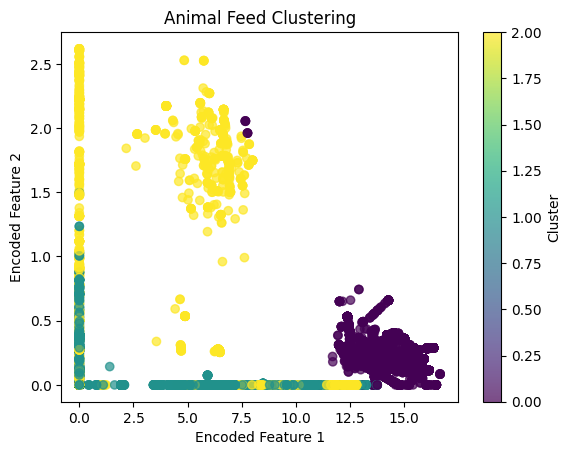

In [29]:

from tensorflow.keras import layers, backend as K

# Define R² Score as a Keras Metric
def r2_keras(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))  # Residual sum of squares
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
    return 1 - (SS_res / (SS_tot + K.epsilon()))  # R² formula

# Define Input Dimension
input_dim = 575  # Matches X_scaled.shape[1]

# Define Autoencoder Model
input_layer = keras.Input(shape=(input_dim,))
encoded = layers.Dense(256, activation="relu")(input_layer)
encoded = layers.Dense(128, activation="relu")(encoded)
encoded = layers.Dense(64, activation="relu")(encoded)
encoded = layers.Dense(10, activation="relu")(encoded)  # Bottleneck layer

decoded = layers.Dense(64, activation="relu")(encoded)
decoded = layers.Dense(128, activation="relu")(decoded)
decoded = layers.Dense(256, activation="relu")(decoded)
decoded = layers.Dense(input_dim, activation="sigmoid")(decoded)  # Reconstruct input

autoencoder = keras.Model(input_layer, decoded)
encoder = keras.Model(input_layer, encoded)  # Extract features later

# Compile Model with MAE & R² Score
autoencoder.compile(optimizer="adam", loss="mse", metrics=["mae", r2_keras])

# Train the Autoencoder
history = autoencoder.fit(X_scaled, X_scaled, epochs=15, batch_size=32, verbose=1)

# Evaluate Model Performance
final_loss, final_mae, final_r2 = autoencoder.evaluate(X_scaled, X_scaled, verbose=0)
print(f"Final Loss (MSE): {final_loss:.4f}")
print(f"Final MAE: {final_mae:.4f}")
print(f"Final R² Score: {final_r2:.4f}")

# Extract Features for Clustering
encoded_features = encoder.predict(X_scaled)

# Apply K-Means Clustering
num_clusters = 3  # Adjust based on feed categories
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(encoded_features)

# Evaluate Clustering
sil_score = silhouette_score(encoded_features, kmeans_labels)
print(f"Silhouette Score: {sil_score:.4f}")

# Visualize Clusters (using first two encoded dimensions)
plt.scatter(encoded_features[:, 0], encoded_features[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel('Encoded Feature 1')
plt.ylabel('Encoded Feature 2')
plt.title('Animal Feed Clustering')
plt.colorbar(label='Cluster')
plt.show()
